In [220]:
# L1="0500.HK"
L1="2800.HK"
# L1="^HSI"
start='2007-01-01'
end=None

In [221]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf 
import talib as TA
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
#
from findiff import FinDiff
from scipy.signal import find_peaks
import pywt

In [222]:
def peak(df,duration):
    peak1=df.rolling(window=duration).max() 
    return(peak1)

def ohlc_gen(stock_code,from1):
    import yfinance as yf
    import talib as TA
    import matplotlib.dates as mdates
    L=[]
    #Fetch daily stock data 
    data = yf.download(stock_code,from1)
    #
    ### Check to make sure they are even number
    if (data.shape[0] % 2) == 1:
        data = data.iloc[1:]
    #
    data["Date"]=data.index
    data["Week"]=data["Date"].dt.week
    data["Year"]=data["Date"].dt.year
    #Create weekly data from daily data
    data_weekly=data[data.index>=from1].groupby(["Year","Week"]).agg(
        {"Date":"first",'Open':'first', 'High':'max', 'Low':'min', 'Close':'last','Volume':'sum'})
    #Add TA in daily and weekly data
    data_weekly["Week"]=data_weekly.index
    data_weekly.index=data_weekly["Date"]
    #
    dayofyear=data['Date'].dt.dayofyear
    data['firstday'] = (dayofyear<dayofyear.shift(1)) | (dayofyear.shift(1).isnull())
    #
    data["EMA9"]=TA.EMA(data["Close"],9)
    data["EMA19"]=TA.EMA(data["Close"],19)
    data["EMA50"]=TA.EMA(data["Close"],50)
    data["RSI9"]=TA.RSI(data["Close"],9)
    data["macd"], data["macdsignal"], data["macdhist"] = TA.MACD(data["Close"], 
                                                           fastperiod=12, 
                                                           slowperiod=26, signalperiod=9)
    #
    data["EMA5"]=TA.EMA(data["Close"],5)
    data["BBupper"], data["BBmid"], data["BBlower"] = TA.BBANDS(data["Close"], 
                                                                timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    data['RSI9-75']=data['RSI9'].rolling(200).apply(lambda x: np.percentile(x, 75))
    data['RSI9-9']=TA.EMA(data["RSI9"],9)
    data['RSI9-19']=TA.EMA(data["RSI9"],19)
    data['RSI9-50']=TA.EMA(data["RSI9"],50)
    data['obv']=TA.OBV(data['Close'], data['Volume'])
    data["obv9"]=TA.EMA(data["obv"],9)
    data["obv19"]=TA.EMA(data["obv"],19)
    data["obv50"]=TA.EMA(data["obv"],50)
    data["chaikin"]=TA.ADOSC(data['High'],data['Low'],data['Close'],data['Volume'], fastperiod=3, slowperiod=10)
    data["chaikin9"]=TA.EMA(data["chaikin"],9)
    data["chaikin19"]=TA.EMA(data["chaikin"],19)
    data["chaikin50"]=TA.EMA(data["chaikin"],50)
    #
    # _, data['resist'], data['resist_angle'], data['peak'], _, data['support'], data['support_angle'], data['trough'], _ = \
    # peak_trough_projection(data, 'Close')
  
    _, data['resist_scipy'], data['resist_angle_scipy'], data['peak_scipy'], \
    _, data['support_scipy'], data['support_angle_scipy'], data['trough_scipy'], _, \
    data['prev_high_scipy'], data['prev_low_scipy'] = \
    peak_trough_projection_pymt_and_scipy(data, 'Close')
    
    #
    data_weekly["EMA9"]=TA.EMA(data_weekly["Close"],9)
    data_weekly["EMA19"]=TA.EMA(data_weekly["Close"],19)
    data_weekly["EMA50"]=TA.EMA(data_weekly["Close"],50)
    #Construct filtered daily and weekly data for chart generation
    ohlc= data[data.index>=from1][['Date', 'Open', 'High', 'Low',
                                   'Close','EMA9','EMA19','EMA50',"RSI9",'RSI9-75',
                                   'EMA5','BBupper','BBmid','BBlower','obv','obv9','obv19','obv50',
                                   'RSI9-9','RSI9-19','RSI9-50',
                                   "chaikin",'chaikin9','chaikin19','chaikin50',
                                   'firstday',
                                   'resist_scipy','support_scipy','peak_scipy',
                                   'trough_scipy','resist_angle_scipy','support_angle_scipy',
                                   'prev_high_scipy', 'prev_low_scipy',
                                   "macd","macdsignal","macdhist",'Volume']].copy()
    ohlc["Date"] = ohlc["Date"].apply(mdates.date2num)
    ohlc_weekly= data_weekly[['Week', 'Open', 'High', 'Low',
                              'Close','EMA9','EMA19','EMA50','Volume']].copy()
    
    L.append(data)
    L.append(ohlc)
    L.append(ohlc_weekly)
    L.append(data_weekly)
    return(L)

In [223]:
def candlestick_gen1(label,ohlc_full,start,end,df=None,list_buy=None,list_sell=None,path1=None):
    import matplotlib.pyplot as pl
    %matplotlib inline
    from mpl_finance import candlestick_ohlc
    import matplotlib.dates as mdates
    
    ohlc = ohlc_full.loc[start:end]
    start_date = datetime.strptime(start, '%Y-%m-%d')
    if end is None:
        end_date = datetime.today()
    else:
        end_date = datetime.strptime(end, '%Y-%m-%d')
    fig = plt.figure(figsize = (15,10))
    plt.title(label, loc='left')
    ax1 = plt.subplot2grid((7,4), (0,0), rowspan=3, colspan=4)
    #
    ax1.plot(ohlc["Date"],ohlc["EMA9"],color="blue",label="EMA9",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["EMA19"],color="red",label="EMA19",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["EMA50"],color="brown",label="EMA50",linewidth=1)
    '''
    ax1.plot(ohlc["Date"],ohlc["BBupper"],color="blue",label="BB upper",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["BBmid"],color="red",label="BB middle",linewidth=1)
    ax1.plot(ohlc["Date"],ohlc["BBlower"],color="brown",label="BB lower",linewidth=1)
    '''
    #
    ax1.grid(True)
    candlestick_ohlc(ax1, ohlc.values, width=.4, 
                     colorup='#53c156', colordown='#ff1717')
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.legend(["Daily"])
    #
    y_lower = min(ohlc["resist_angle_scipy"].min(), ohlc["resist_angle_scipy"].min()) * 0.9
    y_upper = max(ohlc["support_angle_scipy"].max(), ohlc["support_angle_scipy"].max()) * 1.1
    ax1_angle = plt.subplot2grid((7,4), (3,0), sharex=ax1, rowspan=1, colspan=4)
    ax1_angle.grid(True)
    ax1_angle.set_ylim(y_lower, y_upper)
    ax1_angle.plot(ohlc["Date"],ohlc["resist_angle_scipy"],color="blue",label="resist_angle",linewidth=1)
    ax1_angle.plot(ohlc["Date"],ohlc["support_angle_scipy"],color="red",label="support_angle",linewidth=1)    
    
    ax1_OBV = plt.subplot2grid((7,4), (4,0), sharex=ax1, rowspan=1, colspan=4)
    #ax1_OBV.axes.yaxis.set_ticklabels(["RSI9"])
    ax1_OBV.grid(True)
    '''
    ax1_OBV.set_ylim(0, ohlc["RSI9"].max()+10)
    ax1_OBV.plot(ohlc["Date"].values,ohlc["RSI9"].values,color="red",label="RSI9")    
    ax1_OBV.plot(ohlc["Date"].values,ohlc["RSI9-75"].values,color="black",label="RSI9-75")    

    y_lower = min(ohlc["obv9"].min(), ohlc["obv19"].min()) * 0.5
    y_upper = max(ohlc["obv9"].max(), ohlc["obv19"].max()) * 1.1
    ax1_OBV.set_ylim(y_lower, y_upper)
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv9"].values,color="blue",label="obv9")
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv19"].values,color="red",label="obv19")  
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv50"].values,color="brown",label="obv50")
    '''
    #
    # ax1_OBV2 = ax1_OBV.twinx()
    ax1_OBV.set_ylabel('OBV', color='magenta')
    ax1_OBV.set_ylim(ohlc["obv"].min()*0.5, ohlc["obv"].max()*1.5)
    # ax1_OBV2.bar(ohlc["Date"].values, ohlc["obv"].values)
    ax1_OBV.plot(ohlc["Date"].values,ohlc["obv"].values,color="blue",label="obv")
    #
    ax1_RSI = plt.subplot2grid((7,4), (5,0), sharex=ax1, rowspan=1, colspan=4)
    ax1_RSI.set_ylim(0, ohlc["RSI9"].max()+10)
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9"].values,color="black",label="RSI9")
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9-9"].values,color="blue",label="RSI9-9")
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9-19"].values,color="red",label="RSI9-19")
    ax1_RSI.plot(ohlc["Date"].values,ohlc["RSI9-50"].values,color="brown",label="RSI9-50")
    #ax1_RSI.axhline(50,color="blue",linestyle="--")  
    ax1_RSI.grid(True)
    #    
    ax1v = plt.subplot2grid((7,4), (6,0), sharex=ax1, rowspan=1, colspan=4)
    ax1v.axes.yaxis.set_ticklabels(["Volume"])
    ax1v.grid(False)
    ax1v.set_ylim(0, ohlc["Volume"].max())
    ax1v.bar(ohlc["Date"].values,ohlc["Volume"].values)
    #
    ax1_chai = plt.subplot2grid((6,4), (4,0), sharex=ax1, rowspan=1, colspan=4)
    ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin"].values,color="magenta",label="Chaikin A/D")
    ax1_chai.axhline(0,color="black",linestyle="--") 
    # ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin3"].values,color="blue",label="Chaikin SMA 3")
    # ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin5"].values,color="red",label="Chaikin SMA 5")
    # ax1_chai.plot(ohlc["Date"].values,ohlc["chaikin7"].values,color="brown",label="Chaikin SMA 7")
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1_OBV.get_xticklabels(), visible=False)


    plt.subplots_adjust(hspace=0)
    
    ax1.legend(loc="upper left")
    ax1_angle.legend(loc="upper left")
    ax1_OBV.legend(loc="upper right")
    ax1_RSI.legend(loc="upper right")
    ax1_chai.legend(loc="upper right")
    
    for d in ohlc['firstday'][ohlc['firstday']].index:
        ax1.axvline(d,color="black",linestyle="-")
    
    if list_buy is not None:
        if len(list_buy)>0:
            list_buy1=[i for i in list_buy if ((i>=start_date) & (i<=end_date))]
            for x1 in list_buy1:
                ax1.axvline(x1,color="blue",linestyle="--")
        
    if list_sell is not None:
        if len(list_sell)>0:
            list_sell1=[i for i in list_sell if ((i>=start_date) & (i<=end_date))]
            for x1 in list_sell1:
                ax1.axvline(x1,color="red",linestyle="--")
    
    for i, v in ohlc['peak_scipy'][ohlc['peak_scipy']].items():
        ax1.scatter(i, ohlc.loc[i, 'Close'], marker="^", s=100)
    for i, v in ohlc['trough_scipy'][ohlc['trough_scipy']].items(): 
        ax1.scatter(i, ohlc.loc[i, 'Close'], marker="v",s=100)    

    if path1 is not None:
        plt.savefig(path1)


    plt.show()
    
    

In [224]:
def projection_from_last_few_points(data, base_only, x_axis, y_axis, degree, x_range, y_range):
    projection = pd.Series(np.nan, index=data.index)
    angle = pd.Series(np.nan, index=data.index)
    prev_high = pd.Series(np.nan, index=data.index)
    for current_date in data.index:
        prev_all_bases = base_only[base_only.index < current_date]
        if len(prev_all_bases) > 1:
            last_two_bases = prev_all_bases.iloc[-2:].index
            prev_base_index = last_two_bases[-1]
            x_base = x_axis.loc[last_two_bases]
            y_base = y_axis.loc[last_two_bases]
            weights = np.polyfit(x_base, y_base, degree)
            model = np.poly1d(weights)
            projection.loc[current_date] = model(x_axis.loc[current_date])
            #
            angle.loc[current_date] = np.arctan2((y_base[-1]-y_base[0])/y_range, (x_base[-1]-x_base[0]))/x_range * 180 / np.pi
            #
            prev_high[current_date] = data.loc[prev_base_index, 'Close']
            
    return projection, angle, model, prev_high

def peak_trough_projection(data, TA):
    # remove the same consecutive values in data[TA]
    temp = data[TA].copy()
    # temp_next=temp.shift(-1)
    no_redund = pd.DataFrame(temp)
    #
    # find momentum and acceleration
    dx = 1 #1 day interval
    d_dx = FinDiff(0, dx, 1)
    d2_dx2 = FinDiff(0, dx, 2)
    clarr = no_redund.values
    mom = d_dx(clarr)
    momacc = d2_dx2(clarr)
    #
    no_redund['mom'] = mom
    no_redund['momacc'] = momacc
    #
    # peak is array of boolean
    peak1 = (no_redund['momacc']<0) & (no_redund['mom']<0) & (no_redund['mom'].shift(1)>0) & \
            (no_redund['Close']>=no_redund['Close'].shift(1))
    peak2 = (no_redund['momacc'].shift(1)<0) & (no_redund['mom']<0) & (no_redund['mom'].shift(1)>0) & \
            (no_redund['Close'].shift(1)>=no_redund['Close'])
    peak2=peak2.shift(-1)
    peak3 = (no_redund['momacc']<0) & (no_redund['mom']==0) & (no_redund['mom'].shift(1)>0) & \
            (no_redund['mom'].shift(-1)<0)
    peak_sum=peak1 | peak2 | peak3
    peak_noredund=peak_sum[~(peak_sum & peak_sum.shift(-1))]
    peak = pd.Series(False, index=data.index)
    peak=(peak | peak_noredund)
    peak_only = peak[peak]
    #
    # trough is array of boolean
    trough1 = (no_redund['momacc']>0) & (no_redund['mom']>0) & (no_redund['mom'].shift(1)<0) & \
              (no_redund['Close']<=no_redund['Close'].shift(1))
    trough2 = (no_redund['momacc'].shift(1)>0) & (no_redund['mom']>0) & (no_redund['mom'].shift(1)<0) & \
              (no_redund['Close']>=no_redund['Close'].shift(1))
    trough2 = trough2.shift(-1)
    trough3 = ((no_redund['momacc']>0) | ((no_redund['momacc'].shift(-1)>0) & (no_redund['momacc']<0))) & \
              (no_redund['mom']==0) & (no_redund['mom'].shift(1)<0) & \
              (no_redund['mom'].shift(-1)>0)
    trough3 = trough3.shift(1)
    trough_sum = trough1 | trough2 | trough3
    trough_noredund=trough_sum[~(trough_sum & trough_sum.shift(-1))]
    trough = pd.Series(False, index=data.index)
    trough=(trough | trough_noredund)
    trough_only = trough[trough]
    #
    base_date = data.index[0]
    x_axis = pd.Series(data.index.map(lambda date : (pd.Timestamp(date) - base_date).days) + 1, index=data.index)
    y_axis = data[TA]
    #
    degree = 1
    resistance, resist_angle, model_peak, prev_high = projection_from_last_few_points(data, peak_only, x_axis, y_axis, degree)
    support, support_angle, model_trough, prev_low = projection_from_last_few_points(data, trough_only, x_axis, y_axis, degree)
    return x_axis, resistance, resist_angle, peak, model_peak, support, support_angle, trough, model_trough, \
           prev_high, prev_low

In [225]:
def peak_trough_projection_pymt_and_scipy(data, TA):
    # remove the same consecutive values in data[TA]
    temp = data[TA].copy()
    # temp_next=temp.shift(-1)
    no_redund = pd.DataFrame(temp)
    #
    # Clean up with pyw
    Close_raw = no_redund[TA]
    x = Close_raw.values # x is np array               
    (ca, cd) = pywt.dwt(x, "haar")                
    cat = pywt.threshold(ca, np.std(ca), mode="soft")                
    cdt = pywt.threshold(cd, np.std(cd), mode="soft")                
    tx = pywt.idwt(cat, cdt, "haar")
    #
    Close_pywt = pd.Series(tx, index=Close_raw.index)
    #
    # Find support and resistance using scipy
    peaks2, _ = find_peaks(Close_pywt, prominence=1)
    peak = pd.Series(False, index=no_redund.index)
    peak.iloc[peaks2]=True
    #
    Negative_pywt = Close_pywt * -1.0
    troughs2, _ = find_peaks(Negative_pywt, prominence=1)
    trough = pd.Series(False, index=no_redund.index)
    trough.iloc[troughs2]=True    
    
    peak_only = peak[peak]
    trough_only = trough[trough]
    #
    base_date = data.index[0]
    x_axis = pd.Series(data.index.map(lambda date : (pd.Timestamp(date) - base_date).days) + 1, index=data.index)
    x_range = x_axis[-1] - x_axis[0]
    y_axis = data[TA]
    y_range = y_axis[-1] - y_axis[0]
    #
    degree = 1
    resistance, resist_angle, model_peak, prev_high = projection_from_last_few_points(data, peak_only, x_axis, y_axis, degree, x_range, y_range)
    support, support_angle, model_trough, prev_low = projection_from_last_few_points(data, trough_only, x_axis, y_axis, degree, x_range, y_range)
    return x_axis, resistance, resist_angle, peak, model_peak, support, support_angle, trough, model_trough, \
           prev_high, prev_low

In [226]:
#df=yf.download(L1,'2017-01-01')
data_start = datetime.strptime(start, '%Y-%m-%d')
one_year_before = data_start + relativedelta(years=-1)
print('y_finance load date : {}'.format(one_year_before))
#
OHLC_L=ohlc_gen(L1,one_year_before.strftime('%Y-%m-%d'))
#
OHLC=OHLC_L[1]
data=OHLC_L[0]
#   
#candlestick_gen1(OHLC)

y_finance load date : 2006-01-01 00:00:00
[*********************100%***********************]  1 of 1 completed


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


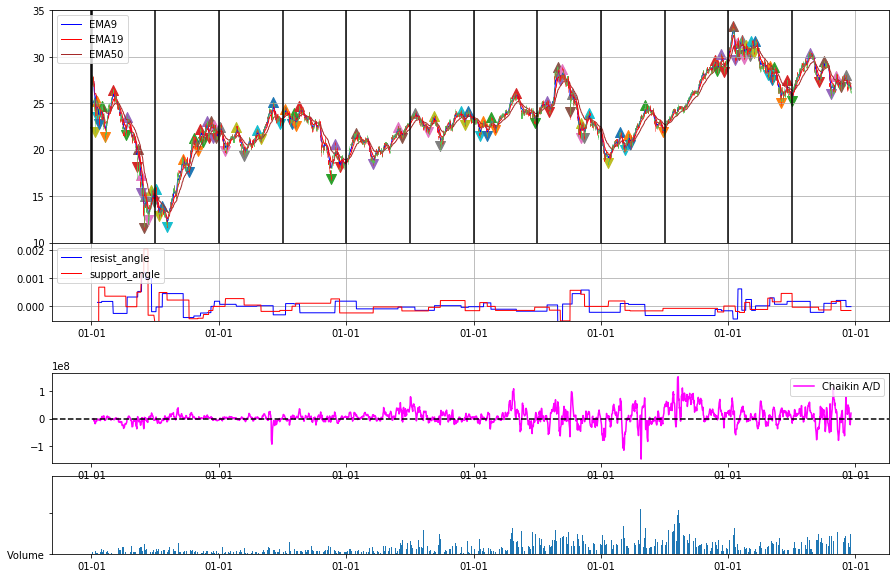

In [227]:
candlestick_gen1(L1,OHLC.loc[start:end],start,end,None,None,None,"fig3.png")

In [228]:
data1=data.loc[start:end].copy()

# Backtesting

In [229]:
def cross_over_up(param):
    df,TA1,TA2=param
    condition = (df[TA1]>df[TA2])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_3(param):
    df,TA1,TA2,TA3=param
    condition = (df[TA1]>df[TA2]) & (df[TA3]<0)
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_2pairs(param):
    df,TA1,TA2,TA3,TA4=param
    condition = (df[TA1]>df[TA2]) & (df[TA3]>df[TA4])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up1(param):
    df,TA1,TA2,TA3 = param
    TA1_TA2=np.where((df[TA1]>df[TA2]) & (df[TA2]>df[TA3]),1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up2(param):
    df,TA1,TA2,TA3,TA4,TA5 = param
    condition = (df[TA1]>df[TA2]) & (df[TA3]>df[TA4]) & (df[TA4]>df[TA5])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_2(param):
    df,TA1,TA2 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & (df_doji > 0)
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_morning_2(param):
    df,TA1,TA2 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    df_morning=TA.CDLMORNINGDOJISTAR(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & ((df_doji > 0) | (df_morning > 0))
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_morning_4(param):
    df,TA1,TA2,TA3,TA4 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    df_morning=TA.CDLMORNINGDOJISTAR(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & (df[TA3]>df[TA4]) & ((df_doji > 0) | (df_morning > 0))
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_doji_3(param):
    df,TA1,TA2,TA3 = param
    df_doji=TA.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    condition = (df[TA1]>df[TA2]) & (df[TA2]>df[TA3]) & (df_doji > 0)
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up4(param):
    df,TA1,TA2,TA3,TA4,TA5 = param
    condition = (df[TA1]>df[TA2]) & (df[TA2]>df[TA3]) & (df[TA4]<df[TA5])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_BBmid_RSI(param):
    df,TA1,TA2,TA3,TA4,TA5,TA6,TA7,TA8 = param
    # Close and High > BBmid + RSI > 50 + OBV-SMA9 > OBV-SMA19
    condition = (df[TA1]>df[TA3]) & (df[TA2]>df[TA3]) & (df[TA4]>50) & (df[TA4]<70) & (df[TA6]>df[TA7]) & (df[TA7]>df[TA8])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_up_BBmid_RSI1(param):
    df,TA1,TA2,TA3,TA4,TA5,TA6,TA7,TA8,TA9,TA10 = param 
    # Close and High > BBmid + RSI < 50 + RSI9-9 > RSI9-19 > RSI9-50 
    # OBV-SMA9 > OBV-SMA19 > OBV-SMA50
    condition = (df[TA1]>df[TA3]) & (df[TA2]>df[TA3]) & \
                (df[TA5]>df[TA6]) & (df[TA6]>df[TA7]) & \
                (df[TA8]>df[TA9]) & (df[TA9]>df[TA10])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

In [230]:
def cross_over_down(param):
    df,TA1,TA2 = param
    TA1_TA2=np.where((df[TA1]-df[TA2])<0,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

def cross_over_down_BB_EMA(param):
    df,TA1,TA2,TA3,TA4,TA5 = param
    condition = (df[TA1]<df[TA2]) & (df[TA3]<df[TA4])
    TA1_TA2=np.where(condition,1,0)
    Enter1=np.pad(np.where(np.diff(TA1_TA2)==1,1,0),(1,0),"constant")
    Enter=pd.Series(Enter1,index=list(df.index))
    return(Enter)

In [231]:
def enter_augment_none(param):
    return True

def augment_cross_over(param):
    df,TA1,TA2 = param
    return df[TA1]>df[TA2]

In [254]:
def stoploss(df,enter,threshold,long):
    Stop_loss_threshold=pd.Series(np.where((enter==1),df["Open"]*threshold,0), index=enter.index)
    Stop_loss_threshold.replace(to_replace=0, method='ffill',inplace=True)
    if long==1:
        stop_loss=np.where((Stop_loss_threshold>=df["Close"]),1,0)
    else:
        stop_loss=np.where((Stop_loss_threshold<=df["Close"]),1,0)
    return(stop_loss)

In [233]:
def strategy(df,enter,exit1,col_list,long,stoploss=None):
    buy_date=[]
    sell_date=[]
    price_buy=[]
    price_sell=[]
    parm_list=[]
    #
    if stoploss is not None:
        exit2=(exit1) | (stoploss)
        exit=np.where(exit2 is True,1,0)
    else:
        exit=exit1
    #
    last_sell = datetime.strptime('01-01-1900', '%m-%d-%Y')
    #
    for i in enter.index[enter==1]:
        try:
            date1=df.index[df.index>i][0]
        except:
            break
        
        if date1 is not None:
            try:
                test=exit[exit==1]
                test1=test[test.index>=date1].index[0]
                test2=df.index[df.index>test1][0]
            except:
                test2=None
        else:
            test2=None
        if i > last_sell:
            buy_date.append(date1)
            sell_date.append(test2)
            if test2 is None:
                # since the no more exit, set last_sell to today to prevent any more enter
                last_sell = datetime.today()
            else:
                last_sell = test1
        
    for i in buy_date:
        if i is not None:
            price=df.loc[i]["Open"]
            price_buy.append(price)
            parm_list.append([df.loc[i,col] for col in col_list])
        else:
            price_buy.append(None)
        
    
    for i in sell_date:
        if i is not None:
            price=df.loc[i]["Open"]
            price_sell.append(price)
        else:
            price_sell.append(None)
        
    tran_dict = {"Date_Buy":buy_date,
                 "Date_Sell":sell_date,
                 "Price_Buy":price_buy,
                 "Price_Sell":price_sell}
    for index, col in enumerate(col_list):
        tran_dict[col] = [l[index] for l in parm_list]
    
    d1=pd.DataFrame(tran_dict)   
    if long==1:
        d1["Gain"]=d1["Price_Sell"]-d1["Price_Buy"]
        d1["Return"]=100*(d1["Price_Sell"]-d1["Price_Buy"])/d1["Price_Buy"]
        d1["Position"]="long"
    else:
        d1["Gain"]=d1["Price_Buy"]-d1["Price_Sell"]
        d1["Return"]=100*(d1["Price_Buy"]-d1["Price_Sell"])/d1["Price_Buy"]
        d1["Position"]="short"
    d1.index=d1["Date_Buy"]
    return(d1)

## EMA cross over strategy

In [234]:
# param = (data1,"macd","macdsignal")
# enter=cross_over_up(param)
# param = (data1,"EMA5","BBmid")
# enter=cross_over_up(param)
param = (data1,"Close","support_scipy")
enter=cross_over_up(param)
# param = (data1,"Close","prev_high_scipy")
# enter=cross_over_up(param)
# param = (data1,"Close","resist_scipy","resist_angle_scipy")
# enter=cross_over_up_3(param)
# param = (data1,"EMA5","BBmid","EMA9","EMA50")
# enter=cross_over_up_2pairs(param)
# param = (data1,"obv9","obv19","obv50")
# enter=cross_over_up1(param)
# param=(data1,"EMA9","EMA19","EMA50")
# enter=cross_over_up1(param)
# param = (data1,"macd","macdsignal","EMA9","EMA19","EMA50")
# enter=cross_over_up2(param)
# param = (data1,"EMA5","BBmid")
# enter=cross_over_up_doji_2(param)
# param = (data1,"EMA5","BBmid")
# enter=cross_over_up_doji_morning_2(param)
# param = (data1,"EMA5","BBmid","EMA9","EMA50")
# enter=cross_over_up_doji_morning_4(param)
# param = (data1,"EMA9","EMA19","EMA50")
# enter=cross_over_up_doji_3(param)
# param = data1,"EMA9","EMA19","EMA50","RSI9","RSI9-75"
# enter=cross_over_up4(param)
# param = (data1,'Close','High','BBmid','RSI9','RSI9-75','obv9','obv19','obv50')
# enter=cross_over_up_BBmid_RSI(param)
# Close and High > BBmid + RSI > 50 + OBV-SMA9 > OBV-SMA19
# param = (data1,'Close','High','BBmid','RSI9','RSI9-9','RSI9-19','RSI9-50','obv9','obv19','obv50')
# enter=cross_over_up_BBmid_RSI1(param)
    # Close and High > BBmid + RSI < 50 + RSI9-9 > RSI9-19 > RSI9-50 
    # OBV-SMA9 > OBV-SMA19 > OBV-SMA50

param = (data1,"EMA9","EMA19")
exit=cross_over_down(param)
param = (data1,"Low","BBlower")
exit1=cross_over_down(param)
param = (data1,"Low","BBlower","EMA9","EMA19","EMA50")
exit3=cross_over_down_BB_EMA(param)

### Display enter and exit

In [235]:
print(enter[enter==1].index.astype(str))
print(exit[exit==1].index.astype(str))

Index(['2008-02-01', '2008-02-12', '2008-08-27', '2008-08-29', '2008-09-18',
       '2008-10-13', '2008-10-28', '2009-01-02', '2009-01-29', '2009-09-03',
       '2009-10-06', '2009-10-30', '2009-11-04', '2009-11-30', '2009-12-23',
       '2010-02-09', '2010-09-02', '2010-12-17', '2010-12-21', '2010-12-29',
       '2011-02-25', '2011-03-18', '2011-08-17', '2011-08-30', '2011-09-07',
       '2011-10-06', '2011-11-28', '2011-12-01', '2012-01-11', '2012-01-13',
       '2012-01-17', '2012-03-27', '2012-06-05', '2012-11-19', '2013-02-28',
       '2013-03-08', '2013-04-19', '2013-06-25', '2013-12-24', '2014-02-06',
       '2014-05-12', '2014-12-18', '2015-05-15', '2015-05-22', '2015-07-09',
       '2016-02-15', '2016-05-20', '2016-05-24', '2016-11-10', '2016-12-29',
       '2017-12-07', '2018-02-13', '2018-03-26', '2018-04-06', '2018-05-31',
       '2018-08-17', '2018-09-13', '2018-10-22', '2018-11-01', '2019-01-04',
       '2019-06-05', '2019-08-15', '2019-10-11', '2019-11-01'],
      dtype=

### Test a ENTER strategy with additional stringent criteria 

In [236]:
enter1 = (enter==1) & (data1['EMA9']>data1['EMA50'])
enter1[enter1==1].index.astype(str)

Index(['2009-09-03', '2009-10-06', '2009-10-30', '2009-11-04', '2009-11-30',
       '2010-09-02', '2012-01-11', '2012-01-13', '2012-01-17', '2012-03-27',
       '2012-11-19', '2015-05-15', '2015-05-22', '2018-03-26', '2018-05-31',
       '2019-11-01'],
      dtype='object')

In [237]:
# exit1[exit1==1].index.astype(str).tolist()
exit2=(exit[exit==1]) | (exit1[exit1==1])

In [238]:
df=strategy(data1,enter,exit3,["RSI9","RSI9-75"],1)
df.style.format({
    'Return': '{:,.2%}'.format
})
df

,Date_Buy,Date_Sell,Price_Buy,Price_Sell,RSI9,RSI9-75,Gain,Return,Position
Date_Buy,,,,,,,,,
2008-02-04,2008-02-04,2008-02-25,24.95,23.60,51.82,nan,-1.35,-5.41,long
2008-08-28,2008-08-28,2008-09-03,21.90,21.40,44.28,nan,-0.50,-2.28,long
2008-09-19,2008-09-19,2008-09-30,19.74,17.26,45.63,nan,-2.48,-12.56,long
2008-10-14,2008-10-14,2008-10-23,17.28,14.50,44.23,nan,-2.78,-16.09,long
2008-10-29,2008-10-29,2008-11-10,13.14,15.08,35.20,nan,1.94,14.76,long
2009-01-05,2009-01-05,2009-01-16,15.60,13.46,67.12,54.29,-2.14,-13.72,long
2009-01-30,2009-01-30,2009-02-13,13.00,13.50,44.42,53.14,0.50,3.85,long
2009-09-04,2009-09-04,2009-11-30,20.20,21.85,55.28,66.33,1.65,8.17,long
2009-12-01,2009-12-01,2009-12-10,21.90,22.00,48.44,67.78,0.10,0.46,long


### Specify period of transaction

In [239]:
print(df[df['Gain']>0].shape)
df[(df['Gain']>0) & (df["RSI9"]<df["RSI9-75"])].shape

(27, 9)


(25, 9)

In [240]:
print(df[df['Gain']<=0].shape)
df[(df['Gain']<=0) & (df["RSI9"]<df["RSI9-75"])].shape

(21, 9)


(15, 9)

In [241]:
tran_start = '2008-01-01'
tran_end = '2008-12-31'
df.loc[tran_start:tran_end]

,Date_Buy,Date_Sell,Price_Buy,Price_Sell,RSI9,RSI9-75,Gain,Return,Position
Date_Buy,,,,,,,,,
2008-02-04,2008-02-04,2008-02-25,24.95,23.60,51.82,nan,-1.35,-5.41,long
2008-08-28,2008-08-28,2008-09-03,21.90,21.40,44.28,nan,-0.50,-2.28,long
2008-09-19,2008-09-19,2008-09-30,19.74,17.26,45.63,nan,-2.48,-12.56,long
2008-10-14,2008-10-14,2008-10-23,17.28,14.50,44.23,nan,-2.78,-16.09,long
2008-10-29,2008-10-29,2008-11-10,13.14,15.08,35.20,nan,1.94,14.76,long


### Display signal in the buy date

In [242]:
pd.options.display.float_format = '{:.2f}'.format
data1.loc[df.index, ['EMA9', 'EMA50']]
# data1.loc[df.index, ['RSI9']]

,EMA9,EMA50
Date_Buy,,
2008-02-04,24.47,nan
2008-08-28,21.53,22.46
2008-09-19,19.53,21.39
2008-10-14,17.18,19.78
2008-10-29,13.88,17.80
2009-01-05,14.97,15.06
2009-01-30,13.30,14.38
2009-09-04,20.39,19.91
2009-12-01,22.28,22.02


In [243]:
buy_list=df.index.tolist()

In [244]:
sell_list=df["Date_Sell"].tolist()

In [245]:
#sell_list=df["Date_Sell"].dt.strftime("%Y-%m-%d").tolist()

### Calculate GAIN

In [246]:
df_sum=df.copy()

In [247]:
GAIN=[]
for i in data1.index:
    if i in list(df_sum.index):
        result=df_sum.loc[i]["Gain"]
    else:
        result=0
    GAIN.append(result)
GAIN_df=pd.Series(GAIN,index=data1.index)     

In [248]:
GAIN_df.dropna().cumsum()[-1]

18.19999885559082

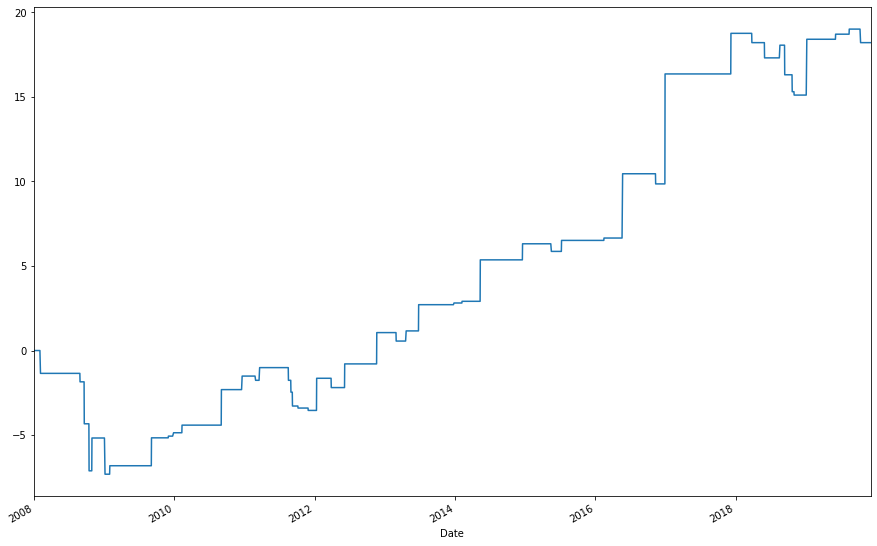

In [249]:
GAIN_df.dropna().cumsum().plot(figsize=(15,10))

### Define Start and End date

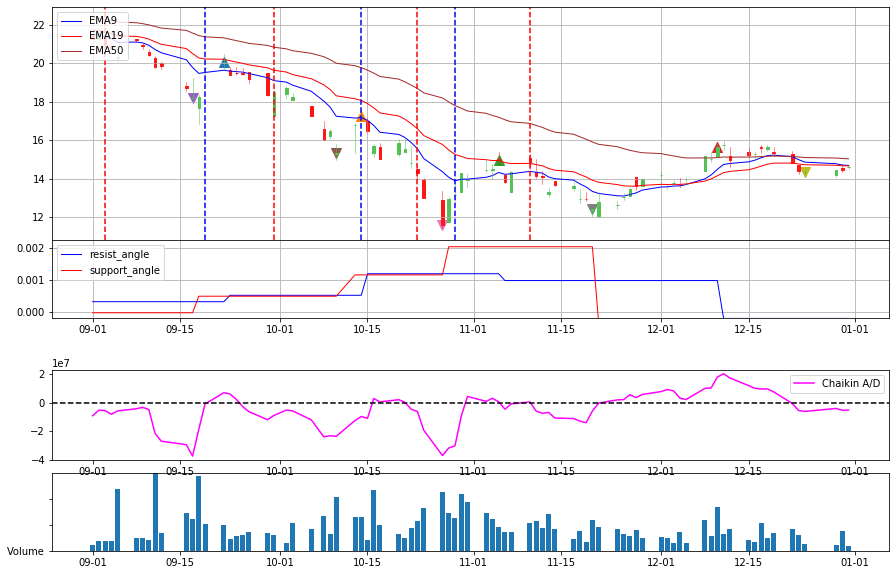

In [250]:
start_chart='2008-09-01'
end_chart='2008-12-31'
#
candlestick_gen1(L1,OHLC.loc[start:end],start_chart,end_chart,data.loc[start:end],buy_list,sell_list,"fig1.png")

In [251]:
data.loc['2011-03-15','prev_high_scipy']

23.899999618530273

In [252]:
data.loc['2011-03-08','Close']

23.899999618530273

### Compare each algorithm

In [255]:
functions_dict = {
    'cross_over_up_macd' : cross_over_up,
    'cross_over_up_BB' : cross_over_up,
    'cross_over_up_resist_scipy' : cross_over_up_3,
    'cross_over_up_support_scipy' : cross_over_up,
    'cross_over_up1_obv' : cross_over_up1,
    'cross_over_up1_EMA' : cross_over_up1,
    'cross_over_up2' : cross_over_up2,
    'cross_over_up_doji_2' : cross_over_up_doji_2,
    'cross_over_up_doji_morning_2' : cross_over_up_doji_morning_2,
    'cross_over_up_doji_3' : cross_over_up_doji_3,
    'cross_over_up4' : cross_over_up4,
    'cross_over_up_BBmid_RSI' : cross_over_up_BBmid_RSI,
    'cross_over_up_BBmid_RSI1' : cross_over_up_BBmid_RSI1,
}
params_dict = {
    'cross_over_up_macd' : (data1,"macd","macdsignal"),
    'cross_over_up_BB' : (data1,"EMA5","BBmid"),
    'cross_over_up_resist_scipy' : (data1,"Close","resist_scipy","resist_angle_scipy"),
    'cross_over_up_support_scipy' : (data1,"Close","support_scipy"),
    'cross_over_up1_obv' : (data1,"obv9","obv19","obv50"),
    'cross_over_up1_EMA' : (data1,"EMA9","EMA19","EMA50"),
    'cross_over_up2' : (data1,"macd","macdsignal","EMA9","EMA19","EMA50"),
    'cross_over_up_doji_2' : (data1,"EMA5","BBmid"),
    'cross_over_up_doji_morning_2' : (data1,"EMA5","BBmid"),
    'cross_over_up_doji_3' : (data1,"EMA9","EMA19","EMA50"),
    'cross_over_up4' : (data1,"EMA9","EMA19","EMA50","RSI9","RSI9-75"),
    'cross_over_up_BBmid_RSI' : (data1,'Close','High','BBmid','RSI9','RSI9-75','obv9','obv19','obv50'),
    'cross_over_up_BBmid_RSI1' : (data1,'Close','High','BBmid','RSI9','RSI9-9','RSI9-19','RSI9-50','obv9','obv19','obv50'),
}
enter_augment_dict = {
    'no_augment' : enter_augment_none,
    'augment_cross_over_EMA_9_50' : augment_cross_over
}
enter_augment_param_dict = {
    'no_augment' : None,
    'augment_cross_over_EMA_9_50' : (data1,'EMA9','EMA50')
}

exit_dict = {
    'cross_over_down_EMA9_EMA19' : cross_over_down,
    'cross_over_down_Low_BBlower' : cross_over_down,
    'cross_over_down_BB_EMA' : cross_over_down_BB_EMA,
}
exit_prem_dict = {
    'cross_over_down_EMA9_EMA19' : (data1,"EMA9","EMA19"),
    'cross_over_down_Low_BBlower' : (data1,"Low","BBlower"),
    'cross_over_down_BB_EMA' : (data1,"Low","BBlower","EMA9","EMA19","EMA50"),
}

start_time = datetime.now()

kpi = dict()
for k_enter, func_enter in functions_dict.items():
    enter_cp = func_enter(params_dict[k_enter])
    for k_augm, func_augm in enter_augment_dict.items():
        augm_cp = func_augm(enter_augment_param_dict[k_augm])
        for k_exit, func_exit in exit_dict.items():
            exit_cp = func_exit(exit_prem_dict[k_exit])
            enter_augcp = (enter_cp==1) & augm_cp
            #
            for stop in [None, stoploss(data1,enter_augcp,0.9,1)]:
                df_cp = strategy(data1,enter_augcp,exit_cp,[],1,stop)
                #
                GAIN=[]
                for i in data1.index:
                    if i in list(df_cp.index):
                        result=df_cp.loc[i]["Gain"]
                    else:
                        result=0
                    GAIN.append(result)
                GAIN_df=pd.Series(GAIN,index=data1.index)
                if stop is None:
                    key = 'NoStopLoss-Enter-{}-Augm-{}-Exit-{}'.format(k_enter, k_augm, k_exit)
                else:
                    key = 'StopLoss-Enter-{}-Augm-{}-Exit-{}'.format(k_enter, k_augm, k_exit)
                kpi[key] = GAIN_df.dropna().cumsum()[-1]
#            
print('Duration = {}'.format(datetime.now() - start_time))

Duration = 0:01:27.368179


In [256]:
for algo in sorted(kpi, key=kpi.get, reverse=True):
    print('{} : {:.2f}'.format(algo, kpi[algo]))

NoStopLoss-Enter-cross_over_up_support_scipy-Augm-no_augment-Exit-cross_over_down_BB_EMA : 18.20
NoStopLoss-Enter-cross_over_up_support_scipy-Augm-no_augment-Exit-cross_over_down_Low_BBlower : 17.58
NoStopLoss-Enter-cross_over_up_support_scipy-Augm-no_augment-Exit-cross_over_down_EMA9_EMA19 : 15.47
NoStopLoss-Enter-cross_over_up_doji_morning_2-Augm-no_augment-Exit-cross_over_down_Low_BBlower : 15.16
NoStopLoss-Enter-cross_over_up_doji_2-Augm-no_augment-Exit-cross_over_down_Low_BBlower : 14.56
NoStopLoss-Enter-cross_over_up_doji_2-Augm-augment_cross_over_EMA_9_50-Exit-cross_over_down_Low_BBlower : 13.90
NoStopLoss-Enter-cross_over_up_doji_morning_2-Augm-augment_cross_over_EMA_9_50-Exit-cross_over_down_Low_BBlower : 13.90
NoStopLoss-Enter-cross_over_up_BBmid_RSI1-Augm-augment_cross_over_EMA_9_50-Exit-cross_over_down_BB_EMA : 13.19
NoStopLoss-Enter-cross_over_up1_EMA-Augm-no_augment-Exit-cross_over_down_BB_EMA : 13.04
NoStopLoss-Enter-cross_over_up1_EMA-Augm-augment_cross_over_EMA_9_50-Ex

### Test getattr

In [257]:
functions_dict = {'cross_over_up1': cross_over_up1}
params_dict = {'cross_over_up1': (data1,"EMA9","EMA19","EMA50")}

mystring = 'cross_over_up1'
if mystring in functions_dict:
    print(functions_dict[mystring](params_dict[mystring]))
    

2007-12-31    0
2008-01-02    0
2008-01-03    0
2008-01-04    0
2008-01-07    0
2008-01-08    0
2008-01-09    0
2008-01-10    0
2008-01-11    0
2008-01-14    0
2008-01-15    0
2008-01-16    0
2008-01-17    0
2008-01-18    0
2008-01-21    0
2008-01-22    0
2008-01-23    0
2008-01-24    0
2008-01-25    0
2008-01-28    0
2008-01-29    0
2008-01-30    0
2008-01-31    0
2008-02-01    0
2008-02-04    0
2008-02-05    0
2008-02-06    0
2008-02-11    0
2008-02-12    0
2008-02-13    0
             ..
2019-10-28    0
2019-10-29    0
2019-10-30    0
2019-10-31    0
2019-11-01    0
2019-11-04    0
2019-11-05    0
2019-11-06    0
2019-11-07    0
2019-11-08    0
2019-11-11    0
2019-11-12    0
2019-11-13    0
2019-11-14    0
2019-11-15    0
2019-11-18    0
2019-11-19    0
2019-11-20    0
2019-11-21    0
2019-11-22    0
2019-11-25    0
2019-11-26    0
2019-11-27    0
2019-11-28    0
2019-11-29    0
2019-12-02    0
2019-12-03    0
2019-12-04    0
2019-12-05    0
2019-12-06    0
Length: 2936, dtype: int